## Main Functions to generate fault characteristics, and sample points

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import random
import math


def random_unit_vector():
    # Generate random spherical coordinates
    theta = random.uniform(0, 2*math.pi)  # Azimuthal angle
    phi = random.uniform(0, math.pi)      # Polar angle

    # Convert spherical coordinates to Cartesian coordinates
    x = math.sin(phi) * math.cos(theta)
    y = math.sin(phi) * math.sin(theta)
    z = math.cos(phi)
    
    return (x, y, z)


def plane_main_axes_from_normal(normal): 
    # Find two axes of plane defined by the center and its normal
    length_axis = random_unit_vector()
    while np.dot(length_axis, normal) < 0.01:
        length_axis = random_unit_vector()

    length_axis = np.cross(normal, length_axis)
    length_axis = length_axis / np.linalg.norm(length_axis)
    width_axis = np.cross(normal, length_axis)

    return length_axis, width_axis


def display_fault_properties(fault_metadata):
    (center, length, width, normal, length_axis, width_axis) = fault_metadata
    print(f"         center: {center} \n         length: {length}, width: {width} \n         length_axis: {length_axis},   width_axis: {width_axis}")

In [36]:
def generate_faults_metadata(n_simple_faults, n_bent_faults, n_cross_faults, n_Y_faults, n_parallel_faults, n_ladder_structures, eps_center=0.1, domain_scale=1, VERBOSE=False):
    """
    Generate metadata characterizing faults via a plane defined by a center, length, width, normal, length_axis, and width_axis.
    
    Args:
    - n_simple_faults:      number of simple planar faults to generate
    - n_bent_faults:        number of bent (bi-planar) faults to generate
    - n_ladder_structures:  number of ladder-like fault structures
    - eps_center:           minimum distance between fault centers
    - domain_scale:         scale=x denotes [-x,x]^3 space. 
    
    Returns:
    - faults_info: List of tuples containing fault metadata (center, length, width, normal, length_axis, width_axis)
    """
    
    # Set fault plane max length and width as proportion of domain
    L_max = 1.5 * domain_scale
    L_min = 1 * domain_scale
    W_max = 0.7 * domain_scale
    W_min= 0.5 * domain_scale
    faults_info = []
    

    # Generate simple fault data
    if VERBOSE:
        print(f"--------------------------------------------------")
        print(f"    Generating {n_simple_faults} simple faults:")
        print(f"--------------------------------------------------")
    for i_simp in range(n_simple_faults):    
        while True: # Ensure centers aren't too close
            center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info):  
                break
        length = np.random.uniform(L_min, L_max)
        width = np.random.uniform(W_min, W_max)
        normal = random_unit_vector()
        length_axis, width_axis = plane_main_axes_from_normal(normal)
        faults_info.append((center, length, width, normal, length_axis, width_axis))

        if VERBOSE:
            print(f"    Simple fault number: {i_simp+1}")
            display_fault_properties((center, length, width, normal, length_axis, width_axis))


    # Generate bent fault data
    if VERBOSE:
        print(f"\n--------------------------------------------------")
        print(f"    Generating {n_bent_faults} bent faults:")
        print(f"--------------------------------------------------")
    for i in range(n_bent_faults):

        # Generate the main fault data
        while True:
            main_center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(main_center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info):  
                break
        main_length = np.random.uniform(L_min, L_max)
        main_width = np.random.uniform(W_min, W_max)
        main_normal = random_unit_vector()
        main_length_axis, main_width_axis = plane_main_axes_from_normal(main_normal)
        faults_info.append((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        if VERBOSE:
            print(f"    Bent fault number: {i//2 + 1}")
            print("       First plane:")
            display_fault_properties((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        # Generate secondary smaller fault: sample plane at an angle
        bent_factor = np.random.uniform(0.6, 0.75)
        bent_length = bent_factor * main_length
        bent_width = bent_factor * main_width 

        # Sample an angle, calculate new axes
        angle = np.random.uniform(-50, 50, size=1)
        alpha = np.cos(np.radians(90 - angle))
        beta = np.sqrt(1-alpha**2)
        bent_length_axis = beta*np.array(main_length_axis)  + alpha*np.array(main_normal)
        bent_length_axis = bent_length_axis / np.linalg.norm(bent_length_axis)
        bent_width_axis = main_width_axis 
        
        bent_center = main_center + 0.5*main_length*main_length_axis + 0.5*bent_length * bent_length_axis
        bent_normal = np.cross(bent_length_axis, bent_width_axis)

        faults_info.append((bent_center, bent_length, bent_width, bent_normal, bent_length_axis, bent_width_axis))

        if VERBOSE:
            print(f"\n       Second plane:")
            print(f"         Angle: {angle}")
            display_fault_properties((bent_center, bent_length, bent_width, bent_normal, bent_length_axis, bent_width_axis))


    # Generate cross fault data
    if VERBOSE:
        print(f"\n--------------------------------------------------")
        print(f"    Generating {n_cross_faults} cross faults:")
        print(f"--------------------------------------------------")
    for k in range(n_cross_faults):

        # Generate main fault data
        while True: 
            cross_center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(cross_center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info): 
                break
        main_length = np.random.uniform(L_min, L_max)
        main_width = np.random.uniform(W_min, W_max)
        main_normal = random_unit_vector()
        main_length_axis, main_width_axis = plane_main_axes_from_normal(main_normal)
        faults_info.append((cross_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        if VERBOSE:
            print(f"    Cross fault number: {k//2 + 1}")
            print("       First plane:")
            display_fault_properties((cross_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        # Generate secondary perpendicular 'crossed' fault
        #cross_factor = np.random.uniform(0.6, 1.4)
        cross_factor = 1
        crossed_length = cross_factor * main_length
        crossed_width = 0.6*cross_factor * main_width 
        crossed_length_axis = main_width_axis 
        crossed_width_axis = main_length_axis 
        crossed_normal = np.cross(crossed_length_axis, crossed_width_axis)
        faults_info.append((cross_center, crossed_length, crossed_width, crossed_normal, crossed_length_axis, crossed_width_axis))

        if VERBOSE:
            print(f"\n       Crosssed plane:")
            display_fault_properties((cross_center, crossed_length, crossed_width, crossed_normal, crossed_length_axis, crossed_width_axis))


    # Generate Y-shaped fault data
    if VERBOSE:
        print(f"\n--------------------------------------------------")
        print(f"    Generating {n_Y_faults} Y - faults:")
        print(f"--------------------------------------------------")
    for l in range(n_Y_faults):

        # Generate main fault data
        while True:
            main_center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(main_center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info):  
                break
        main_length = 1.4 * np.random.uniform(L_min, L_max)
        main_width = 0.7* np.random.uniform(W_min, W_max)
        main_normal = random_unit_vector()
        main_length_axis, main_width_axis = plane_main_axes_from_normal(main_normal)
        faults_info.append((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        if VERBOSE:
            print(f"    Y - fault number: {l//2 + 1}")
            print("       First plane:")
            display_fault_properties((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        # Generate secondary perpendicular 'branched' fault
        branch_length = 0.4*main_length
        branch_width = 0.7*main_width 

        angle = np.random.choice([-1, 1]) * np.random.uniform(20, 35, size=1)
        alpha = np.cos(np.radians(90 - angle))
        beta = np.sqrt(1-alpha**2)
        branch_length_axis = beta*np.array(main_length_axis)  + alpha*np.array(main_normal)
        branch_length_axis = branch_length_axis / np.linalg.norm(branch_length_axis)
        branch_width_axis = main_width_axis    
        branch_normal = np.cross(branch_length_axis, branch_width_axis)    

        branch_center = main_center + np.random.uniform(0, 0.15)*main_length*main_length_axis + 0.5* branch_length * branch_length_axis
   
        
        faults_info.append((branch_center, branch_length, branch_width, branch_normal, branch_length_axis, branch_width_axis))

        if VERBOSE:
            print(f"\n       Branch plane:")
            display_fault_properties((branch_center, branch_length, branch_width, branch_normal, branch_length_axis, branch_width_axis))


    # Generate two parallel fault data
    if VERBOSE:
        print(f"\n--------------------------------------------------")
        print(f"    Generating {n_parallel_faults} parallel faults:")
        print(f"--------------------------------------------------")
    for b in range(n_parallel_faults):

        # Generate main fault data
        while True: 
            main_center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(main_center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info): 
                break
        main_length = np.random.uniform(L_min, L_max)
        main_width = np.random.uniform(W_min, W_max)
        main_normal = random_unit_vector()
        main_length_axis, main_width_axis = plane_main_axes_from_normal(main_normal)
        faults_info.append((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        if VERBOSE:
            print(f"    Parallel pair number: {b//2 + 1}")
            print("       First plane:")
            display_fault_properties((main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis))

        # Generate secondary perpendicular 'crossed' fault
        dist_between_parallels = np.random.uniform(0.5*main_width, 0.7*main_width)
        distance_shifted = np.random.uniform(0.2, 0.7) * main_length
        second_center = main_center + dist_between_parallels * np.array(main_normal) + distance_shifted * main_length_axis
        second_factor = np.random.uniform(0.6, 1.5)
        second_length = second_factor * main_length
        second_width = second_factor * main_width 
        second_length_axis = main_length_axis
        second_width_axis = main_width_axis
        second_normal = np.cross(second_length_axis, second_width_axis)
        faults_info.append((second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis))

        if VERBOSE:
            print(f"\n       Second plane:")
            display_fault_properties((second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis))


    # Generate ladder structures
    if VERBOSE:
        print(f"\n--------------------------------------------------")
        print(f"    Generating {n_ladder_structures} ladder-like structures:")
        print(f"--------------------------------------------------")
    for m in range(n_ladder_structures):

        print(f"    Ladder structure {m+1}")
        # Characterise the first main fault
        while True:
            first_center = np.random.uniform(-domain_scale, domain_scale, size=3)
            if all(np.linalg.norm(first_center - c) > 2 * eps_center for c, _, _, _, _, _ in faults_info):  # Ensure centers aren't too close
                break
        first_length = 1.4 *np.random.uniform(L_min, L_max)
        first_width = np.random.uniform(W_min, W_max)
        first_normal = random_unit_vector()
        first_length_axis, first_width_axis = plane_main_axes_from_normal(first_normal)
        faults_info.append((first_center, first_length, first_width, first_normal, first_length_axis, first_width_axis))            
        if VERBOSE:
            print(f"            Main parallel fault")
            display_fault_properties((first_center, first_length, first_width, first_normal, first_length_axis, first_width_axis))

        # Characterise the second main fault
        dist_between_parallels = np.min(np.array([np.random.uniform(1.5*first_width, 3*first_width), 0.7*first_length]))
        second_center = first_center + dist_between_parallels * np.array(first_normal)
        second_length = first_length
        second_width = first_width
        second_normal = first_normal
        second_length_axis = first_length_axis
        second_width_axis = first_width_axis
        faults_info.append((second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis))

        if VERBOSE:
            print(f"            Second parallel fault")
            display_fault_properties((second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis))

        # Characterise smaller, middle faults: 
        N_smaller_perpendicular_faults = 3
        dist_between_smaller_faults = first_length / (N_smaller_perpendicular_faults+1)
        mid_length = 1.3 *dist_between_parallels
        mid_width = dist_between_parallels / 3

        # They are at a slight angle to the normal: 
        angle = np.random.choice([-1, 1]) * np.random.uniform(10, 20, size=1)
        alpha = np.cos(np.radians(90 - angle))
        beta = np.sqrt(1-alpha**2)
        mid_length_axis = beta*np.array(first_normal)  + alpha*np.array(first_length_axis)
        mid_length_axis = mid_length_axis / np.linalg.norm(mid_length_axis)
        mid_width_axis = first_width_axis
        mid_normal = np.cross(mid_length_axis, mid_width_axis) 
    
        for n in range(N_smaller_perpendicular_faults):
            if n % 2 == 0:
                m = n // 2
            else:
                m = -((n + 1) // 2)
            mid_center = (first_center + second_center)/2 + m*dist_between_smaller_faults*first_length_axis

            faults_info.append((mid_center, mid_length, mid_width, mid_normal, mid_length_axis, mid_width_axis))
            if VERBOSE:
                print(f"\n              Smaller middle fault: fault number {n}")
                display_fault_properties((mid_center, mid_length, mid_width, mid_normal, mid_length_axis, mid_width_axis))
        
    return faults_info

In [43]:
def generate_points_from_plane(center, length, width, normal, length_axis, width_axis, distribution_mode='normal', domain_scale=1):

    density = 150 # points per m^2
    area = length*width 
    num_points = int(np.round(density * area)) 

    # Sample points coordinates on the plane
    x = np.random.uniform(-length/2, length/2, num_points).astype(float)
    y = np.random.uniform(-width/2, width/2, num_points).astype(float)

    # Sample distances from the plane
    # Convention for faults: mean distance ~ width => 4*sigma=width
    if distribution_mode == 'normal':
        distribution_param = width/5
        dist = np.random.normal(loc=0, scale=distribution_param, size=num_points)

    # Compute fault points
    fault_points = center + x[:, None] * length_axis + y[:, None] * width_axis + dist[:, None] * normal

    return fault_points



def generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults, n_cross_faults, n_Y_faults, n_parallel_faults):
     
    """
    Generate point cloud for every fault given its metadata.
    """
    points_list = []
    k = 0
    for i, metadata in enumerate(fault_metadata_list):

        # Add simple faults
        if (i <= n_simple_faults -1) and (n_simple_faults != 0): 
            (center, length, width, normal, length_axis, width_axis) = metadata
            points_list.append(generate_points_from_plane(center, length, width, normal, length_axis, width_axis))


        # Add bent faults, make sure to merge main-bent points into one list
        elif (i>=n_simple_faults) and (i <= n_simple_faults + 2 * n_bent_faults -1) and (n_bent_faults != 0): 
            if k%2 == 0: # main points
                (main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis) = metadata
                main_fault_points = generate_points_from_plane(main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis)
                k+=1
            else:        # bent points
                (second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis) = metadata
                second_fault_points = generate_points_from_plane(second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis)

                # Concatenate main and bent points into one array, and add to list.
                points_list.append(np.concatenate((main_fault_points, second_fault_points)))
                k+=1


        # Add cross faults (a cross consists of two faults, hence they are separate)
        elif   (i >= n_simple_faults + 2*n_bent_faults) and (i <= n_simple_faults + 2*n_bent_faults + 2*n_cross_faults -1) and (n_cross_faults != 0):
            (center, length, width, normal, length_axis, width_axis) = metadata
            points_list.append(generate_points_from_plane(center, length, width, normal, length_axis, width_axis))


        # Add Y-shaped faults
        elif   (i >= n_simple_faults + 2*n_bent_faults + 2*n_cross_faults) and (i <= n_simple_faults + 2*n_bent_faults + 2*n_cross_faults + 2*n_Y_faults -1) and (n_Y_faults != 0):
            if k%2 == 0: # main points
                (main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis) = metadata
                main_fault_points = generate_points_from_plane(main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis)
                k+=1
            else:        # branch points
                (second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis) = metadata
                second_fault_points = generate_points_from_plane(second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis)

                # Concatenate main and bent points into one array, and add to list.
                points_list.append(np.concatenate((main_fault_points, second_fault_points)))
                k+=1


        # Add parallel faults
        elif    (i >= n_simple_faults + 2*n_bent_faults + 2*n_cross_faults + 2*n_Y_faults) and (i <= n_simple_faults + 2*n_bent_faults + 2*n_cross_faults + 2*n_Y_faults -1 + 2*n_parallel_faults -1) and (n_parallel_faults != 0):
            if k%2 == 0: # main points
                (main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis) = metadata
                main_fault_points = generate_points_from_plane(main_center, main_length, main_width, main_normal, main_length_axis, main_width_axis)
                k+=1
            else:        # parallel points
                (second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis) = metadata
                second_fault_points = generate_points_from_plane(second_center, second_length, second_width, second_normal, second_length_axis, second_width_axis)

                # Concatenate main and parallel points into one array, and add to list.
                points_list.append(np.concatenate((main_fault_points, second_fault_points)))
                k+=1


        # Add rest of faults that form the ladder structure
        else: 
            (center, length, width, normal, length_axis, width_axis) = metadata
            points_list.append(generate_points_from_plane(center, length, width, normal, length_axis, width_axis))

        
    return points_list


def generate_dataset(n_simple_faults, n_bent_faults, n_cross_faults, n_Y_faults, n_parallel_faults, n_structures, VERBOSE=False):

    fault_metadata_list = generate_faults_metadata(n_simple_faults, n_bent_faults, n_cross_faults, n_Y_faults, n_parallel_faults, n_structures, eps_center=0.1, domain_scale=1, VERBOSE=False)

    fault_points_list = generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults, n_cross_faults, n_Y_faults, n_parallel_faults)
    
    return fault_points_list

### Visualization functions

In [5]:
def multi_static_plot_better(fault_points_list, fault_metadata_list=None, show_plane=False, show_axes=False):
    """
    Visualize fault points in 3D and optionally plot the plane and axes.

    Args:
    - fault_points_list: List of fault points arrays (each array represents points for one fault)
    - fault_metadata_list: List of fault metadata tuples (each tuple contains metadata for one fault)
    - show_plane: Boolean indicating whether to plot the plane (default is False)
    - show_axes: Boolean indicating whether to plot the axes (default is False)
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot event points for each fault
    for i, fault_points in enumerate(fault_points_list):
        ax.scatter(fault_points[:, 0], fault_points[:, 1], fault_points[:, 2], label=f'Fault {i+1}', s=5)

    # Plot the plane and axes if requested
    if show_plane or show_axes or fault_metadata_list != None:
        for metadata in fault_metadata_list:
            # Unpack plane data
            (center, length, width, normal, length_axis, width_axis) = metadata

            if show_plane:
                # Define vertices of the plane
                plane_vertices = center + np.array([-length/2, length/2, length/2, -length/2, -length/2])[:, None] * length_axis + np.array([-width/2, -width/2, width/2, width/2, -width/2])[:, None] * width_axis

                # Plot the plane
                ax.plot_trisurf(plane_vertices[:, 0], plane_vertices[:, 1], plane_vertices[:, 2], color='blue', alpha=0.2)

            if show_axes:
                # Plot length and width axes
                ax.plot([center[0], center[0] + length_axis[0]*length/2],
                        [center[1], center[1] + length_axis[1]*length/2],
                        [center[2], center[2] + length_axis[2]*length/2], color='red', linewidth=3)

                ax.plot([center[0], center[0] + width_axis[0]*width/2],
                        [center[1], center[1] + width_axis[1]*width/2],
                        [center[2], center[2] + width_axis[2]*width/2], color='green', linewidth=3)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Synthetic Seismic Data - Fault Points')
    ax.legend()
    plt.show()

In [53]:
def multi_interactive_plot_better(fault_points_list, fault_metadata_list, show_plane=False, show_axes=False, domain_scale=1):
    """
    Visualize 3D points of multiple faults in an interactive plot using Plotly.
    """

    fig = go.Figure()

    x_range_largest = [-1, 1]
    y_range_largest = x_range_largest
    z_range_largest = x_range_largest
    
    for i, points in enumerate(fault_points_list):
        # Extract x, y, z coordinates from points
        x_coords = points[:, 0]
        y_coords = points[:, 1]
        z_coords = points[:, 2]

        # Plot the points
        fig.add_trace(go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode='markers',
            marker=dict(
                size=3,
                opacity=0.8
            ),
            name=f'Fault {i+1}'
        ))

    if show_plane or show_axes or fault_metadata_list != None:
        j=0
        print(fault_metadata_list[0])
        for metadata in fault_metadata_list:
            # Unpack plane data:
            (center, length, width, normal, length_axis, width_axis) = metadata

            if show_plane:
                # Define vertices of the plane
                plane_vertices = center + np.array([-length/2, length/2, length/2, -length/2, -length/2])[:, None] * length_axis + np.array([-width/2, -width/2, width/2, width/2, -width/2])[:, None] * width_axis

                plane_trace = go.Mesh3d(x=plane_vertices[:, 0],
                                        y=plane_vertices[:, 1],
                                        z=plane_vertices[:, 2],
                                        i=[0, 1, 2, 0],
                                        j=[1, 2, 3, 4],
                                        k=[2, 3, 4, 0],
                                        opacity=0.2,
                                        color='blue',
                                        )
                fig.add_trace(plane_trace)

            if show_axes:
                # Plot length and width axes
                length_axis_trace = go.Scatter3d(x=[center[0], center[0] + length_axis[0]*length/2],
                                                y=[center[1], center[1] + length_axis[1]*length/2],
                                                z=[center[2], center[2] + length_axis[2]*length/2],
                                                mode='lines',
                                                line=dict(color='red', width=3),
                                                )

                width_axis_trace = go.Scatter3d(x=[center[0], center[0] + width_axis[0]*width/2],
                                                y=[center[1], center[1] + width_axis[1]*width/2],
                                                z=[center[2], center[2] + width_axis[2]*width/2],
                                                mode='lines',
                                                line=dict(color='green', width=3),
                                                )
                fig.add_trace(length_axis_trace)
                fig.add_trace(width_axis_trace)
            j+=1
            
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title='3D Visualization of Fault Points'
    )

    fig.show()

## Example outputs

--------------------------------------------------
    Generating 0 simple faults:
--------------------------------------------------

--------------------------------------------------
    Generating 0 bent faults:
--------------------------------------------------

--------------------------------------------------
    Generating 1 cross faults:
--------------------------------------------------
    Cross fault number: 1
       First plane:
         center: [0.48445608 0.54627439 0.31258014] 
         length: 1.2853258572169848, width: 0.6174231367578584 
         length_axis: [-0.99608454 -0.08493973 -0.02451186],   width_axis: [ 0.04799937 -0.28677534 -0.95679463]

       Crosssed plane:
         center: [0.48445608 0.54627439 0.31258014] 
         length: 1.2853258572169848, width: 0.370453882054715 
         length_axis: [ 0.04799937 -0.28677534 -0.95679463],   width_axis: [-0.99608454 -0.08493973 -0.02451186]

--------------------------------------------------
    Generating 0 Y

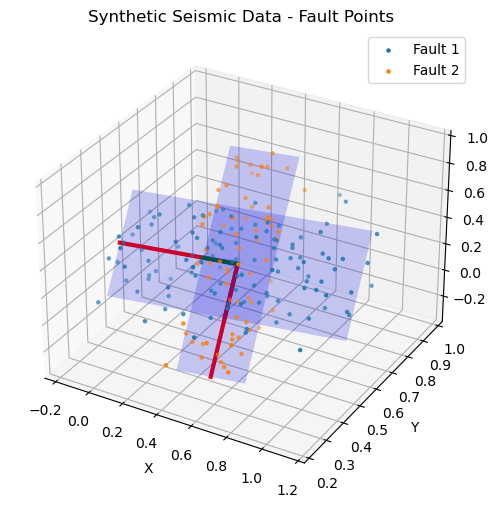

(array([0.48445608, 0.54627439, 0.31258014]), 1.2853258572169848, 0.6174231367578584, (0.07424048078059264, -0.9542248940195698, 0.28972953361162107), array([-0.99608454, -0.08493973, -0.02451186]), array([ 0.04799937, -0.28677534, -0.95679463]))


In [54]:
n_simple_faults = 0
n_bent_faults = 0
n_cross_faults = 1
n_Y_faults = 0
n_parallel_faults = 0
n_structures = 0

# Generate fault metadata 
fault_metadata_list = generate_faults_metadata(n_simple_faults, n_bent_faults, n_cross_faults, n_Y_faults, n_parallel_faults, n_structures, eps_center=0.1, domain_scale=1, VERBOSE=True)

# Generate point cloud for the fault 
fault_points_list = generate_point_list_from_metadata_list(fault_metadata_list, n_simple_faults, n_bent_faults, n_cross_faults, n_Y_faults, n_parallel_faults)

multi_static_plot_better(fault_points_list, fault_metadata_list, show_plane=True, show_axes=True)
multi_interactive_plot_better(fault_points_list, fault_metadata_list, show_plane=True, show_axes=True)


## Generating a larger dataset

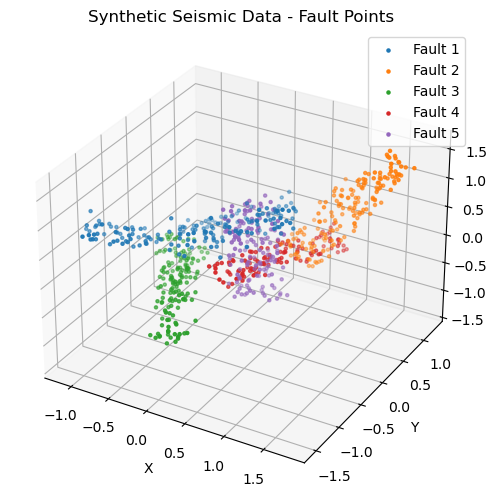

In [56]:
fault_points_list = generate_dataset(n_simple_faults=0, n_bent_faults=2, n_cross_faults=0, n_Y_faults=2, n_parallel_faults=1, n_structures=0, VERBOSE=False)

multi_static_plot_better(fault_points_list, None, show_plane=False, show_axes=False)
multi_interactive_plot_better(fault_points_list, None, show_plane=False, show_axes=False)